# Sequential Importance sampling

In this notebook, we use importance sampling to approximate the posterior distribution of the latent variables in a Non-Markovian Gaussian sequence model.

We consider a non-Markovian Gaussian sequence model (NM-GSM) of the form

$$
\begin{aligned}
    f_t(x_t \vert x_{t-1}) &= \mathcal{N}(x_t \vert \phi x_{t-1}, q),\\
    g_t(y_t \vert x_{1:t}) &= \mathcal{N}\left(y_t \big\vert \sum_{k=1}^t \beta^{t-k} x_k, r\right).
\end{aligned}
$$


Suppose we know the values $\boldsymbol\theta = (\phi, q, \beta, r)$ that govern the sequence model.


$$
\begin{aligned}
    \text{Sample:  } & x_{t}^{(s)} \sim q_t(x_t \vert x_{1:t-1}^{(s)})\\
    \text{Append:  } & x_{1:t}^{(s)} = (x_{1:t}^{(s)}, x_t^{(s)}) \\
    \text{Weight:  } & \tilde w^{(s)}_t =  \tilde w_{t-1}^{(s)} \frac{\tilde\gamma_t\left(x_{1:t-1}^{(s)}\right)}
                      {\tilde\gamma_{t-1}\left(x_{1:t-1}^{(s)}\right) q_t\left(x_t^{(s)} \vert x_{1:t-1}^{(s)}\right)}
\end{aligned}
$$

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jax
import distrax
import seaborn as sns
import pandas as pd
import jax.numpy as jnp
import matplotlib.pyplot as plt
from functools import partial
from jsmc.datagen import non_markovian_gsm as nmgsm
from jsmc.samplers import sequential_importance_sampling as sis

In [3]:
plt.rcParams["figure.figsize"] = [6.4, 4.0]
%config InlineBackend.figure_format = "retina"

## Sampling NM-GSM

In [154]:
key = jax.random.PRNGKey(3141)
key_sample, key_filter = jax.random.split(key)

num_steps = 100
params = nmgsm.ModelParameters(phi=0.0, q=1.0, beta=0.0, r=0.2)
simulation = nmgsm.simulate(key_sample, params, num_steps)

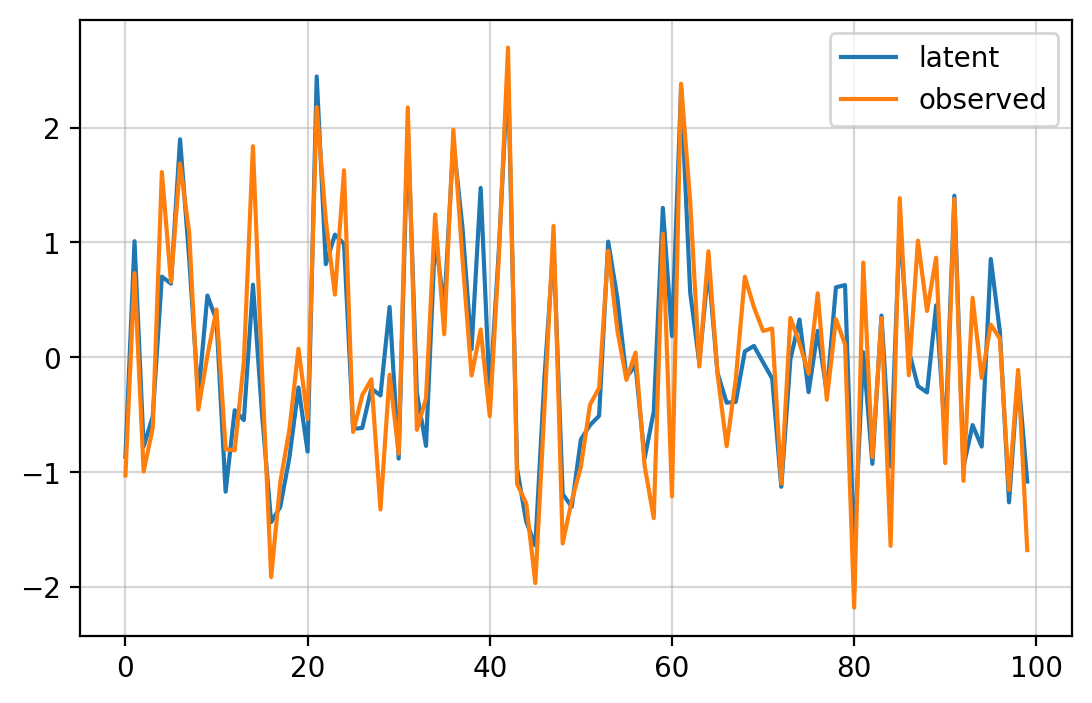

In [155]:
plt.plot(simulation.x, label="latent")
plt.plot(simulation.y, label="observed")
plt.legend()
plt.grid(alpha=0.5)

In [156]:
class Proposal:
    def __init__(self, params):
        self.params = params
    
    def get_last_ix(self, state):
        counter = state.vcounter
        ix_min = counter.argmin() 
        return ix_min - 1
    
    def sample(self, key, state: sis.StateSIS):
        phi = self.params.phi
        q = self.params.q
        ix_last = self.get_last_ix(state)  
        last_val = state.particles[ix_last]
        
        eps = jax.random.normal(key)
        value = phi * last_val + jnp.sqrt(q) * eps
        return value
    
    def logpdf(self, x, state: sis.StateSIS):
        phi = self.params.phi
        q = self.params.q
        
        last_ix = self.get_last_ix(state)
        last_sample = state.particles[last_ix]
        
        dist_norm = distrax.Normal(loc=last_sample * phi, scale=jnp.sqrt(q))
        return dist_norm.log_prob(x)
    
    
    
class Target:
    def __init__(self, params):
        self.params = params
    
    def logpdf(self, state):
        lprobs = nmgsm.log_joint(state.particles, state.observations, self.params)
        log_likelihood = jnp.einsum("n,n->", lprobs, state.vcounter)
        return log_likelihood

In [157]:
proposal = Proposal(params)
target = Target(params)

In [158]:
eval_state_single = sis.eval(key_filter, simulation.y, target, proposal)

In [159]:
jax.tree_map(jnp.shape, eval_state_single)

StateSIS(particles=(100,), observations=(100,), vcounter=(100,), log_weights=(100,))

## Estimating the marginal log-likelihood

$$
    Z_t \approx \frac{1}{S} \sum_{s=1}^S \tilde{w}_t^{(s)} =: \hat{Z}_t
$$

CPU times: user 751 ms, sys: 87.2 ms, total: 838 ms
Wall time: 704 ms


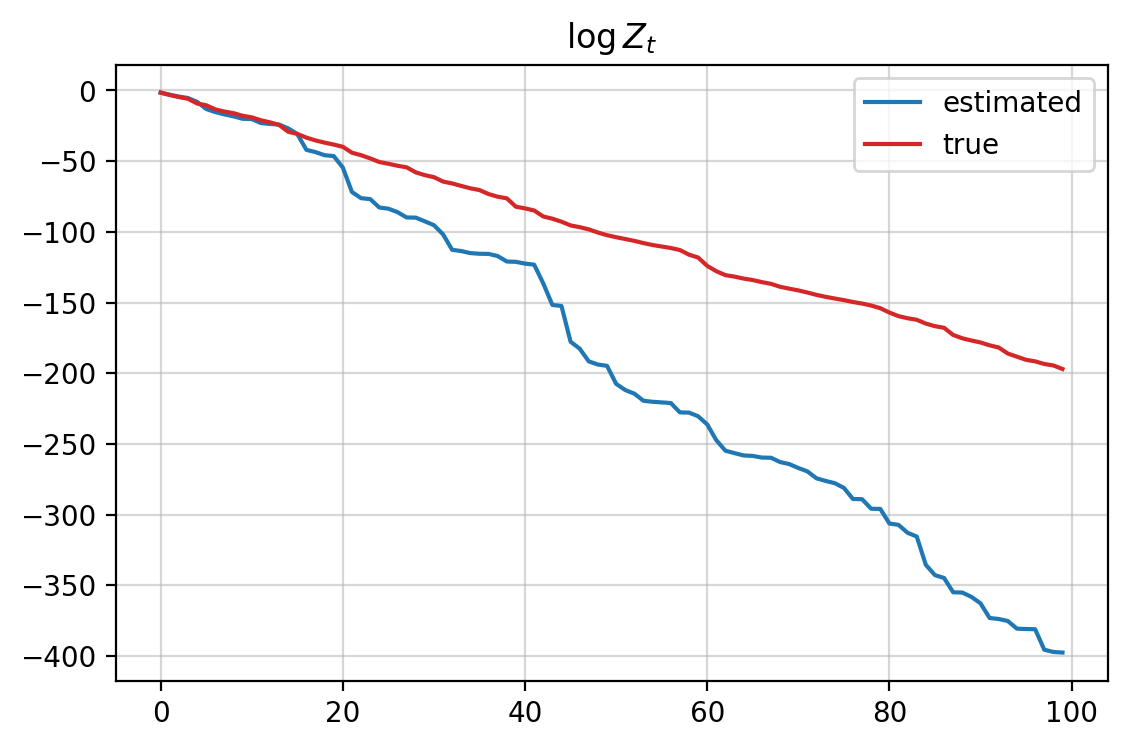

In [160]:
%%time
num_particles = 100
keys_filter = jax.random.split(key_filter, num_particles)

vmap_eval = jax.vmap(sis.eval, (0, None, None, None))
eval_state = vmap_eval(keys_filter, simulation.y, target, proposal)

mll_est = jax.nn.logsumexp(eval_state.log_weights, b=1/num_particles, axis=0)
mll_true = nmgsm.log_joint(simulation.x, simulation.y, params).cumsum()

plt.plot(mll_est, label="estimated")
plt.plot(mll_true, label="true", c="tab:red")
plt.title(r"$\log Z_t$")
plt.legend()
plt.grid(alpha=0.5)

CPU times: user 5.12 s, sys: 126 ms, total: 5.24 s
Wall time: 4.46 s


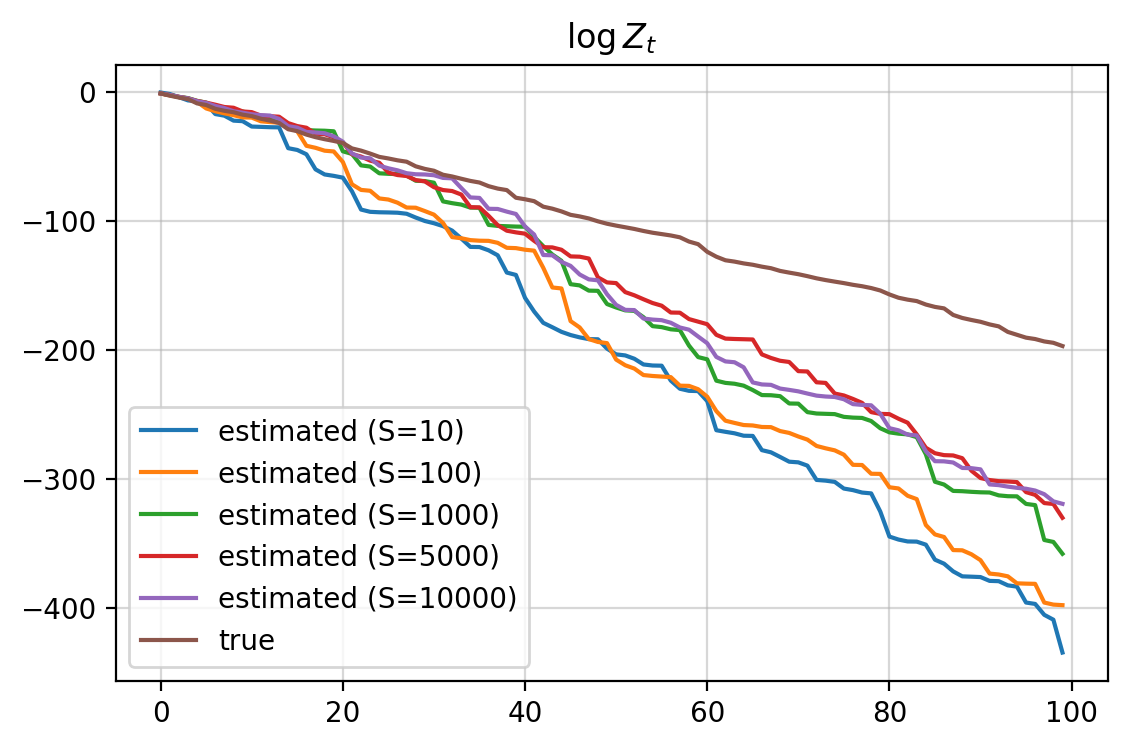

In [161]:
%%time

list_num_particles = [10, 100, 1000, 5000, 10_000]
mll_true = nmgsm.log_joint(simulation.x, simulation.y, params).cumsum()
for num_particles in list_num_particles:
    keys_filter = jax.random.split(key_filter, num_particles)

    vmap_eval = jax.vmap(sis.eval, (0, None, None, None))
    eval_state = vmap_eval(keys_filter, simulation.y, target, proposal)
    
    mll_est = jax.nn.logsumexp(eval_state.log_weights, b=1/num_particles, axis=0)
    plt.plot(mll_est, label=f"estimated (S={num_particles})")

plt.plot(mll_true, label="true")
plt.title(r"$\log Z_t$")
plt.legend()
plt.grid(alpha=0.5)

## Comparing results

In [162]:
log_weights_last = eval_state.log_weights[:, -1]
weights_last = jnp.exp(log_weights_last - jax.nn.logsumexp(log_weights_last))

In [163]:
x_hat = jnp.einsum("st,s->t", eval_state.particles, weights_last)

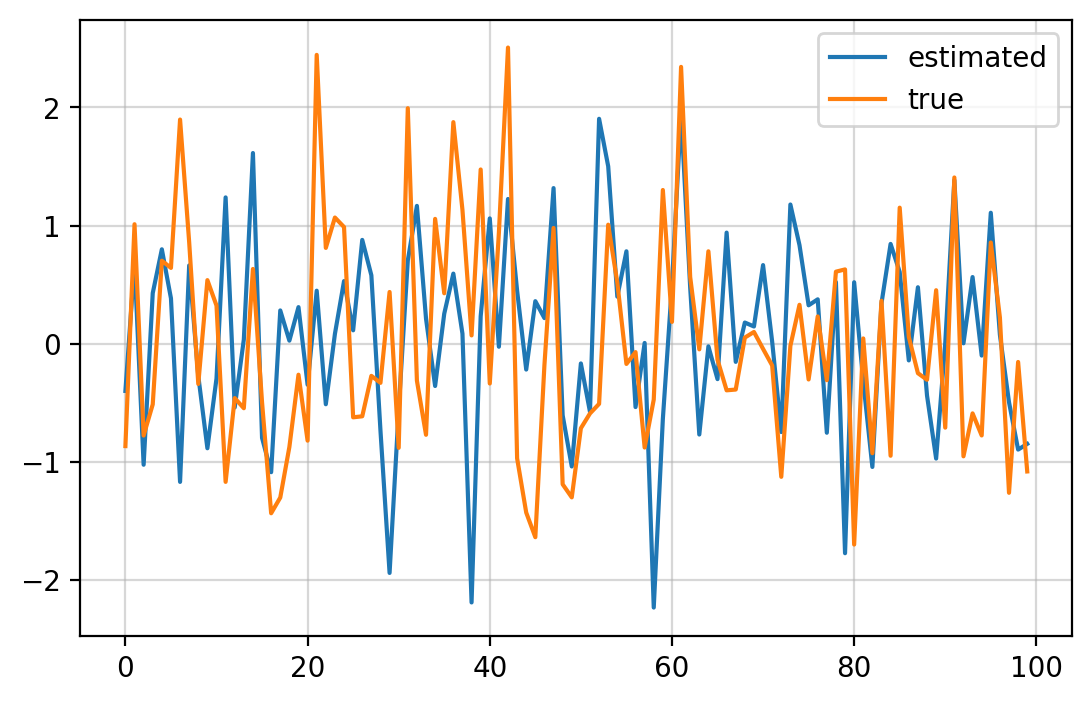

In [164]:
plt.plot(x_hat, label="estimated")
plt.plot(simulation.x, label="true")
plt.grid(alpha=0.5)
plt.legend()

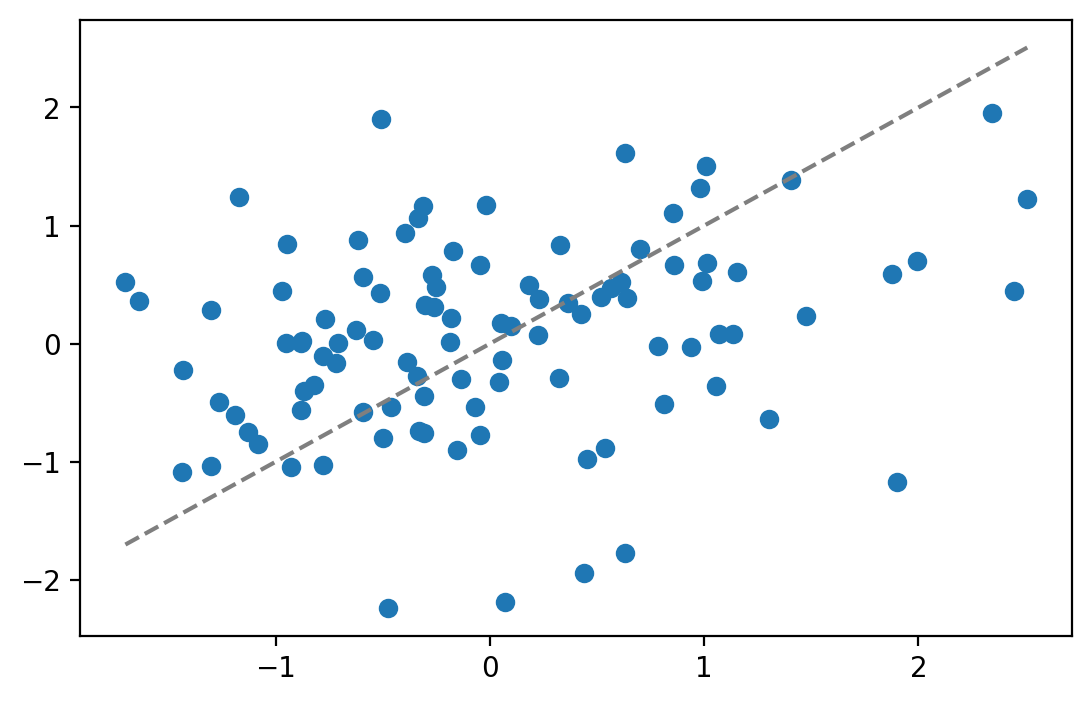

In [165]:
videntity = jnp.linspace(simulation.x.min(), simulation.x.max())
plt.scatter(simulation.x, x_hat)
plt.plot(videntity, videntity, c="tab:gray", linestyle="--")